In [1]:
%matplotlib inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from itertools import product

def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

from scipy.stats import binned_statistic_2d

In [2]:
data=pd.read_csv('yellow_tripdata_2016-06.csv', parse_dates=[1,2],
                usecols=range(7))

#### Фильтруем выбросы - создаем 4 маски

In [3]:
mask_dist=data.trip_distance>0

In [4]:
mask_time=(data.tpep_dropoff_datetime>data.tpep_pickup_datetime)

In [5]:
mask_long=((data.pickup_longitude>=-74.25559) & (data.pickup_longitude<=-73.70001))

In [6]:
mask_lat=((data.pickup_latitude>=40.49612) & (data.pickup_latitude<=40.91553))

In [7]:
mask_pas=data.passenger_count>0

#### до фильтрации

In [8]:
data.shape[0]

11135470

#### после фильтрации

In [9]:
df=data.loc[mask_dist & mask_long & mask_lat & mask_time & mask_pas]

In [10]:
df.shape[0]

10936041

#### Отбрасываем минуты и секунды

In [11]:
df.tpep_pickup_datetime=df.tpep_pickup_datetime.dt.floor('1h')

In [20]:
NY_viz=pd.DataFrame(df[['pickup_longitude', 'pickup_latitude']].values, index=df.tpep_pickup_datetime, columns=['lon', 'lat'])

In [23]:
NY_viz.to_csv('NY_viz.csv')

In [24]:
pd.read_csv('NY_viz.csv', index_col=0, parse_dates=True)

,lon,lat
tpep_pickup_datetime,,
2016-06-09 21:00:00,-73.983360,40.760937
2016-06-09 21:00:00,-73.981720,40.736668
2016-06-09 21:00:00,-73.994316,40.751072
2016-06-09 21:00:00,-73.982361,40.773891
2016-06-09 21:00:00,-73.987106,40.733173
...,...,...
2016-06-21 22:00:00,-73.971756,40.765923
2016-06-21 22:00:00,-73.989693,40.735512
2016-06-21 22:00:00,-73.973473,40.763695


#### Аггрегация

In [148]:
regions=pd.read_csv('regions.csv', sep=';')

In [149]:
statistic = binned_statistic_2d(df['pickup_longitude'].values, 
                                   df['pickup_latitude'].values,
                                   df.passenger_count,            #### Тут может использоваться любой столбец
                                   statistic='count', 
                                  bins=[np.union1d(regions.west, regions.east), 
                                        np.union1d(regions.south, regions.north)], 
                                  expand_binnumbers=True)
                                  
df['region'] = (statistic[3][0] - 1) * 50 + statistic[3][1]

#### Создание таблицы, в котрой индекс - время, а колонки - номера квадратов. Значения - количество поездок из данного квадрата в час

In [150]:
agg=pd.DataFrame(index=np.unique(df.tpep_pickup_datetime), columns=regions.region.values)

def shape0(df):
    return df.shape[0]

a=df[['tpep_pickup_datetime', 'region', 'VendorID']].groupby(['tpep_pickup_datetime', 'region']).apply(shape0)

b=a.unstack()

b.fillna(0, inplace=True)

agg.fillna(0, inplace=True)

c=agg+b

c.fillna(0, inplace=True)

c=c.astype(int)

##### b - это таблица, в которой нет полностью нулевых столбцов
##### с - полная таблица

In [151]:
c.iloc[:5, 1123:1140]

,1124,1125,1126,1127,1128,1129,1130,1131,1132,1133,1134,1135,1136,1137,1138,1139,1140
2016-05-01 00:00:00,0,81,259,535,691,994,1100,193,27,0,0,0,0,0,0,0,0
2016-05-01 01:00:00,0,38,121,465,686,1024,1292,310,6,0,0,0,0,0,0,0,0
2016-05-01 02:00:00,0,34,86,410,621,843,1368,327,5,0,0,0,0,0,0,0,0
2016-05-01 03:00:00,0,23,59,241,355,591,1250,342,4,0,0,0,0,0,0,0,0
2016-05-01 04:00:00,0,22,64,148,155,297,701,191,2,0,0,0,0,0,0,0,0


##### Проверка сохранности данных

In [152]:
b.sum().sum()

11626521.0

In [153]:
c.sum().sum()

11626521

#### Empire state building

In [154]:
N=40.7484
W=-73.9857

In [155]:
regions.loc[((regions.west<=W) & (regions.east>=W) &
(regions.south<=N) & (regions.north>=N))].region.values

array([1231], dtype=int64)

Text(0, 0.5, '$Количество поездок$')

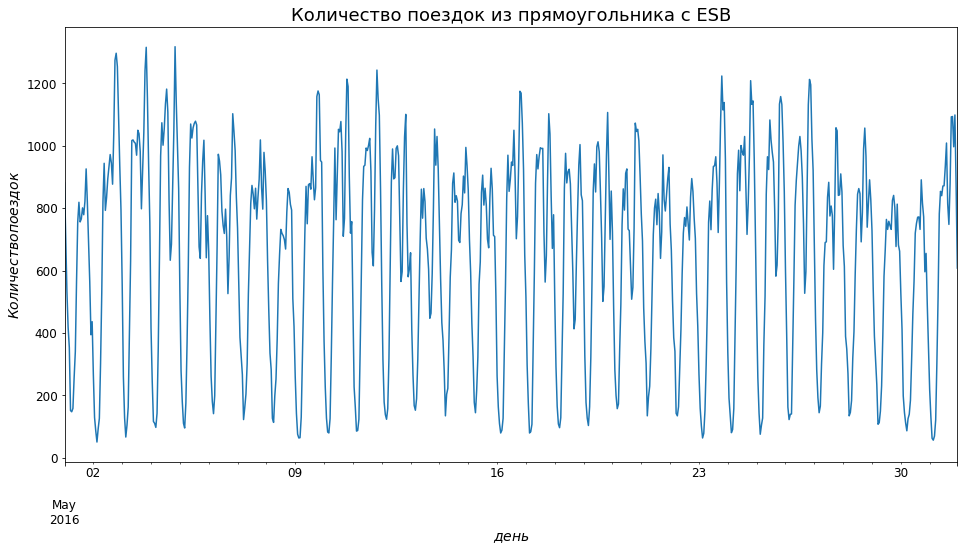

In [156]:
plt.figure()
b[1231].plot(figsize=(16,8), fontsize=12)
plt.title('Количество поездок из прямоугольника с ESB', fontsize=18)
plt.xlabel('$день$', fontsize=14)
plt.ylabel('$Количество поездок$', fontsize=14)

#### Пар час-ячейка без поездок

In [157]:
print(f'Ячеек без поездки было: {(c==0).sum().sum()}')

Ячеек без поездки было: 1718238
